In [1]:
from dlc_practical_prologue import generate_pair_sets

nSamples = 1000
data = generate_pair_sets(nSamples)
var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
train_input, train_target, train_classes, test_input, test_target, test_classes = data
stringWidth = 20
for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
    print('{:s}  {:s}  {:s}'.format(
        var_names[i].ljust(stringWidth),
        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
        'dtype'.ljust(stringWidth)))

train_input            1000 x 2 x 14 x 14   dtype               
train_target                  1000          dtype               
train_classes               1000 x 2        dtype               
test_input             1000 x 2 x 14 x 14   dtype               
test_target                   1000          dtype               
test_classes                1000 x 2        dtype               


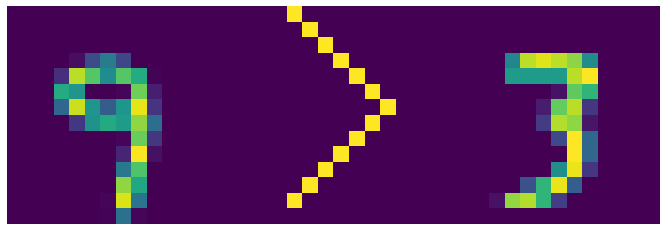

In [2]:
from utils import show_pair

show_pair(train_input, train_target, 0)

## Without using the information from the classes

In [3]:
from utils import train_model
from models.net1 import Net1
import torch
import torch.nn as nn

model = Net1(50)
criterion = nn.BCEWithLogitsLoss()
eta = 1e-3
mini_batch_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
nb_epochs = 10


        
train_model(model, train_input, train_target.float(), test_input, test_target, nb_epochs, mini_batch_size, optimizer, criterion)

/home/relja/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Epoch 0: loss 9.317 / train accuracy 74.5%, test accuracy 75.5
Epoch 1: loss 4.865 / train accuracy 79.1%, test accuracy 78.1
Epoch 2: loss 4.139 / train accuracy 82.7%, test accuracy 79.3
Epoch 3: loss 3.826 / train accuracy 84.2%, test accuracy 80.3
Epoch 4: loss 3.217 / train accuracy 87.3%, test accuracy 80.2
Epoch 5: loss 2.713 / train accuracy 90.2%, test accuracy 83.5
Epoch 6: loss 2.359 / train accuracy 91.2%, test accuracy 84.0
Epoch 7: loss 2.155 / train accuracy 91.2%, test accuracy 82.6
Epoch 8: loss 2.179 / train accuracy 93.1%, test accuracy 82.2
Epoch 9: loss 1.737 / train accuracy 92.9%, test accuracy 82.6


In [4]:
nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The model has {:d} trainable parameters'.format(nParams))

The model has 29789 trainable parameters


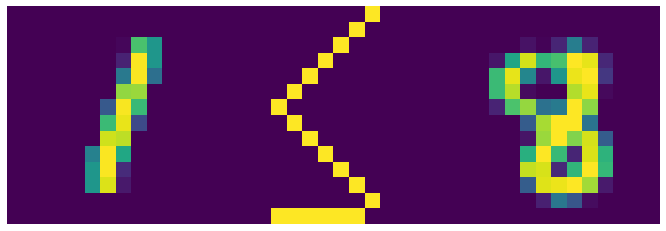

In [5]:
predictions = model(test_input)
show_pair(test_input, predictions, 10)

## With class information during training

In [6]:
from utils import train_model_double_objective
from models.net2 import Net2

model = Net2(50)
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.CrossEntropyLoss()
eta = 1e-3
mini_batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
nb_epochs = 10


        
train_model_double_objective(model, train_input, train_target.float(), 
                             train_classes, test_input, test_target, 
                             test_classes, nb_epochs, mini_batch_size, optimizer, 
                             criterion, criterion2, beta = 1)

Epoch 0: loss 388.714 / train accuracy 76.5%, test accuracy 75.1
Epoch 1: loss 171.221 / train accuracy 82.2%, test accuracy 79.6
Epoch 2: loss 125.203 / train accuracy 81.6%, test accuracy 82.4
Epoch 3: loss 95.913 / train accuracy 85.5%, test accuracy 82.9
Epoch 4: loss 77.334 / train accuracy 90.3%, test accuracy 86.5
Epoch 5: loss 67.874 / train accuracy 87.3%, test accuracy 85.5
Epoch 6: loss 63.980 / train accuracy 90.6%, test accuracy 84.8
Epoch 7: loss 55.017 / train accuracy 89.9%, test accuracy 86.7
Epoch 8: loss 52.288 / train accuracy 90.0%, test accuracy 85.2
Epoch 9: loss 41.541 / train accuracy 91.5%, test accuracy 87.1


In [7]:
def accuracy_of_digit_class(model, input_, classes, mini_batch_size = 10):
  nb_errors = 0
  for b in range(0, input_.size(0), mini_batch_size): 
    _, out1, _ = model(input_.narrow(0, b, mini_batch_size))
    _, pred = torch.max(out1, dim=1)
    gt = classes.narrow(0, b, mini_batch_size)[:, 0]
    nb_errors += (pred != gt).sum().item()
  N = input_.shape[0]
  return 100*(N-nb_errors)/N

In [8]:
print("Accuracy: {:.2f}".format(accuracy_of_digit_class(model, test_input, test_classes)))

Accuracy: 92.50
